<a href="https://colab.research.google.com/github/EstomJr/classificacao-pisi3/blob/main/Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalando bibliotecas necessárias no Google Colab
!pip install shap
!pip install imbalanced-learn

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import pickle

In [ ]:
# Carregar o dataset
df = pd.read_csv('/content/aac_intakes_outcomes.csv', on_bad_lines='skip')

In [ ]:
# 2. Limpeza e preparação dos dados
# Agrupamento de raças
def agrupar_racas(raca):
    raca = raca.replace(" Mix", "").strip()
    if "/" in raca:
        raca = raca.split("/")[0].strip()
    return raca

df['breed_grouped'] = df['breed'].apply(agrupar_racas)

In [ ]:
# Exibir as raças agrupadas
def exibir_racas_agrupadas():
    racas_agrupadas = df['breed_grouped'].value_counts()
    print("\nRaças agrupadas e suas contagens:")
    print(racas_agrupadas.head(10))  # Mostrar as 10 raças mais comuns

exibir_racas_agrupadas()


Raças agrupadas e suas contagens:
breed_grouped
Domestic Shorthair       23817
Pit Bull                  6865
Labrador Retriever        6260
Chihuahua Shorthair       5726
German Shepherd           2612
Domestic Medium Hair      2464
Bat                       2208
Australian Cattle Dog     1442
Domestic Longhair         1298
Dachshund                 1239
Name: count, dtype: int64


In [ ]:
# Criando a variável alvo: 'status'
def categorizar_outcome(outcome):
    if outcome in ['Euthanasia', 'Died']:
        return 'Morto'
    elif outcome == 'Adoption':
        return 'Adotado'
    else:
        return 'Não Adotado'

df['status'] = df['outcome_type'].apply(categorizar_outcome)

In [ ]:
# Selecionar colunas de interesse e remover valores nulos
selected_columns = ['age_upon_intake_(years)', 'intake_condition', 'animal_type', 'breed_grouped',
                    'color', 'sex_upon_intake', 'time_in_shelter_days', 'status']

df = df[selected_columns]
df = df.dropna()

In [ ]:
# Dicionário de tradução das labels
traducoes = {
    "time_in_shelter_days": "Tempo no Abrigo (dias)",
    "age_upon_intake_(years)": "Idade na Entrada (anos)",
    "sex_upon_intake_Unknown": "Sexo na Entrada: Desconhecido",
    "intake_condition_Normal": "Condição de Entrada: Normal",
    "animal_type_Cat": "Tipo de Animal: Gato",
    "sex_upon_intake_Spayed Female": "Sexo na Entrada: Fêmea Esterilizada",
    "sex_upon_intake_Neutered Male": "Sexo na Entrada: Macho Esterilizado",
    "breed_grouped_Pit Bull": "Raça: Pit Bull",
    "animal_type_Dog": "Tipo de Animal: Cachorro",
    "breed_grouped_Bat": "Raça: Morcego",
    "sex_upon_intake_Intact Male": "Sexo na Entrada: Macho Intacto",
    "intake_condition_Injured": "Condição de Entrada: Ferido",
    "color_Black": "Cor: Preto",
    "breed_grouped_Raccoon": "Raça: Guaxinim",
    "breed_grouped_Domestic Shorthair": "Raça: Doméstico de Pelo Curto",
    "intake_condition_Other": "Condição de Entrada: Outra",
    "breed_grouped_Chihuahua Shorthair": "Raça: Chihuahua de Pelo Curto",
    "breed_grouped_Dachshund": "Raça: Dachshund",
    "intake_condition_Nursing": "Condição de Entrada: Amamentando",
    "animal_type_Other": "Tipo de Animal: Outro",
    "color_group_brown": "Cor: Marrom",
    "color_group_white": "Cor: Branco",
    "intake_condition_Sick": "Condição de Entrada: Doente",
    "color_Black/White": "Cor: Preto/Branco",
    "color_group_others": "Cor: Outras",
    "breed_grouped_Labrador Retriever": "Raça: Labrador Retriever",
    "color_Black/Brown": "Cor: Preto/Marrom",
    "color_group_blue": "Cor: Azul"
}

In [ ]:
# Função para traduzir as labels no DataFrame do SHAP
def traduzir_labels(features, traducoes):
    return [traducoes.get(feature, feature) for feature in features]

In [ ]:
# Separando as variáveis preditoras (X) e a variável alvo (y)
X = df.drop(columns=['status'])
y = df['status']

In [ ]:
# Codificar variáveis categóricas em X (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

In [ ]:
# Garantir que todas as classes sejam consistentes
le = LabelEncoder()
le.fit(['Não Adotado', 'Adotado', 'Morto'])  # Incluir todas as classes possíveis

# Codificar os conjuntos de treino e teste
y_train_res_encoded = le.transform(y_train_res)  # Codificar as strings para inteiros
y_test_encoded = le.transform(le.inverse_transform(y_test))  # Reverter e codificar novamente para garantir consistência

# Confirmar as classes após codificação
print("Classes codificadas em y_train_res_encoded:", pd.Series(y_train_res_encoded).unique())
print("Classes codificadas em y_test_encoded:", pd.Series(y_test_encoded).unique())


Classes codificadas em y_train_res_encoded: [2 0 1]
Classes codificadas em y_test_encoded: [2 0 1]


In [ ]:
# Dividindo o conjunto de dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [ ]:
# 7. Lidar com o desequilíbrio de classes usando SMOTE
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
# Função para exibir a Matriz de Confusão e Classificação
def exibir_resultados(modelo, nome_modelo):
    y_pred = modelo.predict(x_test)
    y_pred_decoded = le.inverse_transform(y_pred)  # Decodificar rótulos para as classes originais

    # Avaliação do modelo
    print(f"\nRelatório de Classificação - {nome_modelo}")
    print(classification_report(le.inverse_transform(y_test), y_pred_decoded, target_names=le.classes_))

    # Exibindo a matriz de confusão
    cm = confusion_matrix(le.inverse_transform(y_test), y_pred_decoded, labels=le.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{nome_modelo} - Matriz de Confusão')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Verdadeira')
    plt.show()

    # Exibindo a acurácia do modelo
    print(f"Acurácia - {nome_modelo}: {accuracy_score(le.inverse_transform(y_test), y_pred_decoded)}")

In [ ]:
# Função para exibir SHAP plots para classificação multiclasse em barras
def exibir_shap(modelo, x_test, nome_modelo):

    x_test_amostra = x_test.sample(n=100, random_state=42)

    # Traduzir os nomes das colunas antes de calcular os valores SHAP
    x_test_amostra_traduzido = x_test_amostra.rename(columns=traducoes)

    # Criar o explicador SHAP
    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer.shap_values(x_test_amostra)


    if len(shap_values.shape) == 3:  # Multiclasse
        for i, classe in enumerate(le.classes_):
            print(f"Classe: {classe}")
            shap.summary_plot(
                shap_values[:, :, i],
                x_test_amostra_traduzido,
                plot_type="bar",
                show=False
            )
            plt.title(f"SHAP Summary Plot (Bar Plot) - Classe: {classe}")
            plt.show()
    else:
        print("Formato inesperado de shap_values:", shap_values.shape)



Relatório de Classificação - Random Forest
              precision    recall  f1-score   support

 Não Adotado       0.71      0.75      0.73     10079
     Adotado       0.72      0.65      0.68      2080
       Morto       0.74      0.72      0.73     11743

    accuracy                           0.73     23902
   macro avg       0.72      0.71      0.72     23902
weighted avg       0.73      0.73      0.73     23902



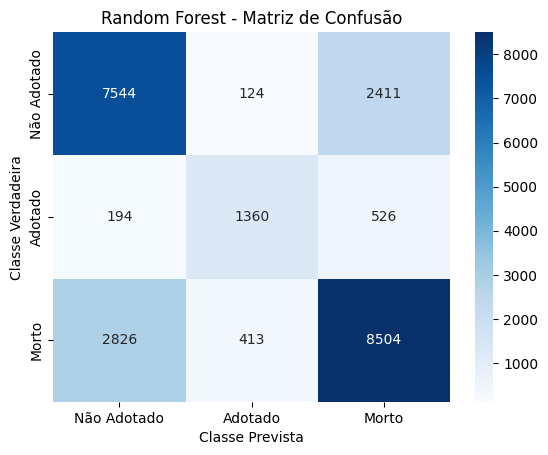

Acurácia - Random Forest: 0.7283072546230441


In [ ]:
# 8. Treinamento do modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train_res, y_train_res)
exibir_resultados(model_rf, "Random Forest")


Relatório de Classificação - Decision Tree
              precision    recall  f1-score   support

 Não Adotado       0.71      0.71      0.71     10079
     Adotado       0.63      0.67      0.65      2080
       Morto       0.73      0.71      0.72     11743

    accuracy                           0.71     23902
   macro avg       0.69      0.70      0.69     23902
weighted avg       0.71      0.71      0.71     23902



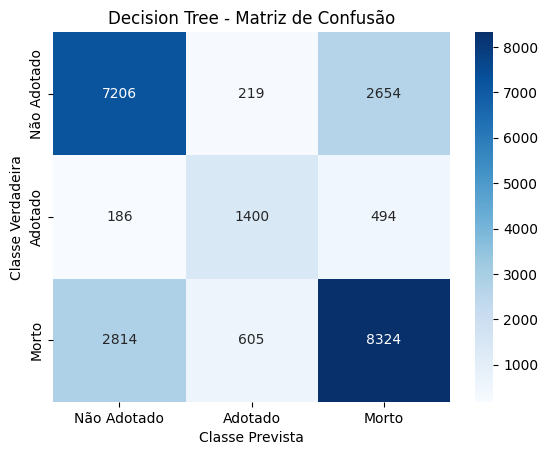

Acurácia - Decision Tree: 0.7083089281231696


In [ ]:
# 9. Treinamento do modelo Decision Tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(x_train_res, y_train_res)
exibir_resultados(model_dt, "Decision Tree")


Relatório de Classificação - XGBoost
              precision    recall  f1-score   support

     Adotado       0.72      0.84      0.78     10079
       Morto       0.78      0.68      0.73      2080
 Não Adotado       0.81      0.71      0.75     11743

    accuracy                           0.76     23902
   macro avg       0.77      0.74      0.75     23902
weighted avg       0.77      0.76      0.76     23902



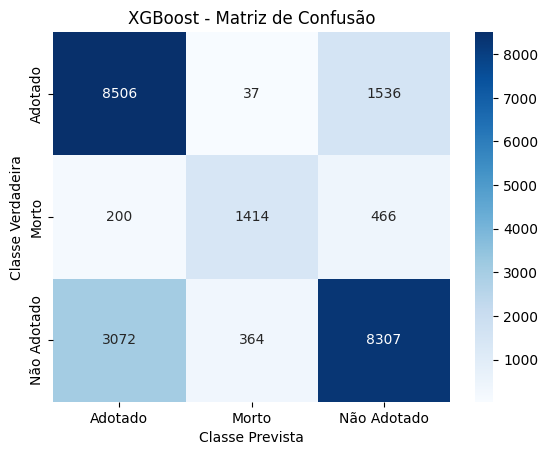

Acurácia - XGBoost: 0.7625721696929127


In [ ]:
# Treinamento do modelo XGBoost
model_xgb = XGBClassifier(objective="multi:softprob", num_class=3, random_state=42)
model_xgb.fit(x_train_res, y_train_res_encoded)
exibir_resultados(model_xgb, "XGBoost")

Classe: Adotado


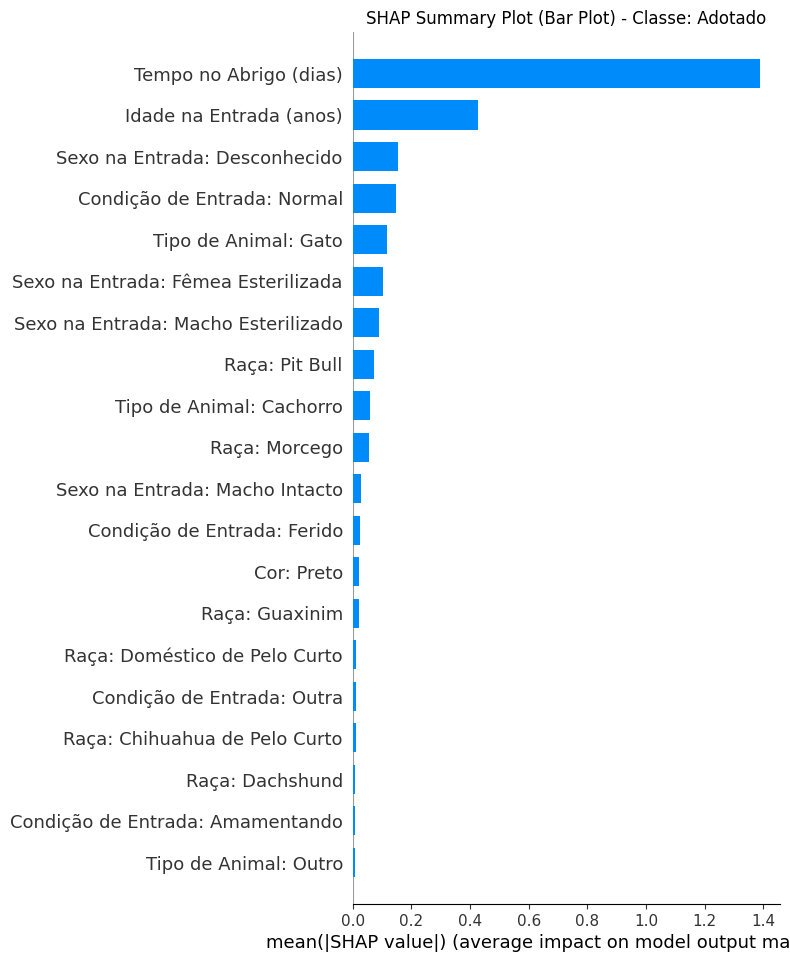

Classe: Morto


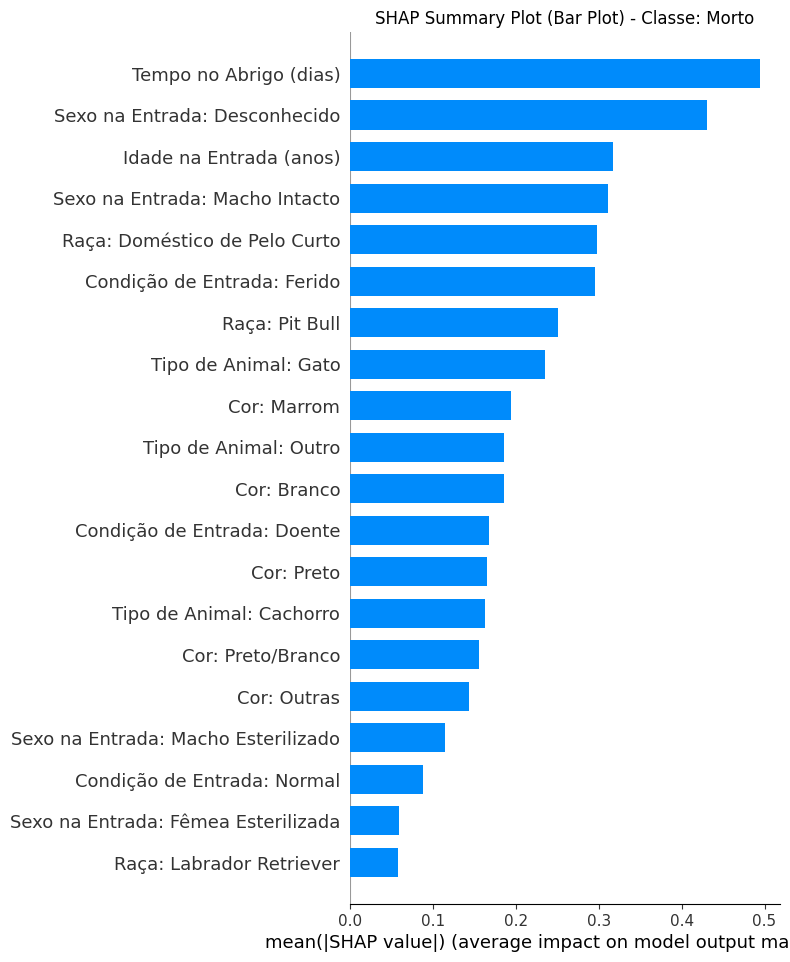

Classe: Não Adotado


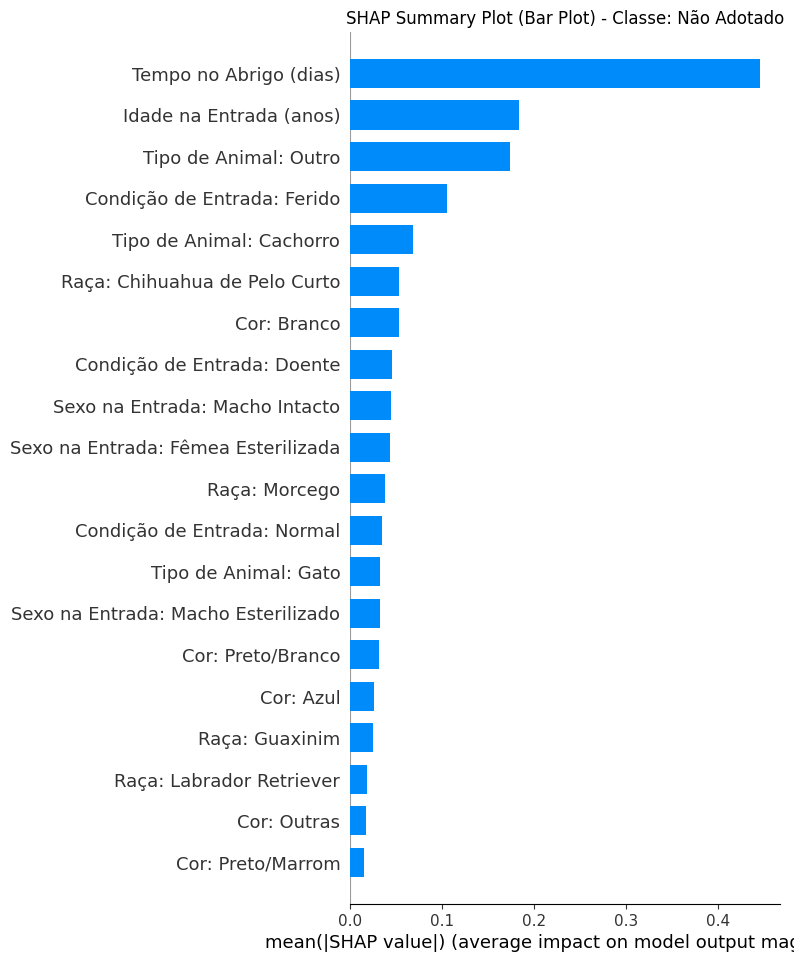

In [ ]:
# Exibir o SHAP plot para XGBoost
exibir_shap(model_xgb, x_test, "XGBoost")

In [ ]:
# Salvando todos os modelos em um único arquivo .pkl
modelos_treinados = {
    'RandomForest': model_rf,
    'DecisionTree': model_dt,
    'GradientBoosting': model_xgb,
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test
}

In [ ]:
# Salvando o dicionário de modelos em um único arquivo .pkl
with open('/content/modelos_treinados.pkl', 'wb') as file:
    pickle.dump(modelos_treinados, file)

# Carregando os modelos e dados para verificar se o salvamento foi bem-sucedido
with open('/content/modelos_treinados.pkl', 'rb') as file:
    modelos_treinados_carregados = pickle.load(file)

# Exibindo os modelos e dados carregados para confirmar que foram salvos corretamente
for nome, conteudo in modelos_treinados_carregados.items():
    if nome in ['x_train', 'y_train', 'x_test', 'y_test']:
        print(f"{nome} carregado com sucesso: Conjunto de dados")
    else:
        print(f"{nome} carregado com sucesso: {conteudo}")

RandomForest carregado com sucesso: RandomForestClassifier(random_state=42)
DecisionTree carregado com sucesso: DecisionTreeClassifier(random_state=42)
GradientBoosting carregado com sucesso: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)
x_train carregado com sucesso: Conjunto de dados
y_train

In [ ]:
# Testando a previsão com o modelo carregado do Gradient Boosting para garantir que o modelo ainda funciona
modelo_gb_carregado = modelos_treinados_carregados['GradientBoosting']  # Usando a variável correta

# Carregando o x_test e y_test do arquivo pickle
x_test_carregado = modelos_treinados_carregados['x_test']  # Usando a variável correta
y_test_carregado = modelos_treinados_carregados['y_test']  # Usando a variável correta

# Realizando a previsão
y_pred_carregado = modelo_gb_carregado.predict(x_test_carregado)


In [ ]:
# Exibindo o resultado de uma amostra de previsões do modelo carregado
print("\nPrevisões do modelo Gradient Boosting carregado (amostra):")
print(y_pred_carregado[:10])


Previsões do modelo Gradient Boosting carregado (amostra):
[2 2 0 0 2 1 0 2 0 0]


In [ ]:
# Confirmando a acurácia do modelo carregado
print(f"Acurácia do modelo Gradient Boosting carregado: {accuracy_score(y_test, y_pred_carregado)}")

Acurácia do modelo Gradient Boosting carregado: 0.7625721696929127
